<a href="https://colab.research.google.com/github/xelothi/Machine-Learning-for-Bacteria-Identification-From-UTI-samples/blob/main/XAI_base_ordinal_encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 6.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score,train_test_split, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
import shap
shap.initjs()

# Initial data wrangling

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Master_data/CSV/Bolnicki/bolnicki_filled.csv", index_col=[0])
train_df

,Spol,Dob,Mjesto,Datum nar.,Odjel,Tra?eno,Naziv bakterije,ESBL,CRE,Antibiogram,...,LZD,NN,MP,TEC,TZP.1,XL,PEF,CEF,FOS,CZA
0,Z,86,MOSTAR,1/2/2017,2200,Urin-aerobno,Esch. coli,missing,N,D,...,missing,missing,missing,missing,missing,missing,missing,missing,S,missing
1,Z,8,MOSTAR,1/2/2017,4170,Urin-aerobno,Esch. coli,missing,N,D,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,Z,10,MOSTAR,1/2/2017,4330,Urin-aerobno,Esch. coli,missing,N,D,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
3,Z,92,MOSTAR,1/4/2017,12200,Urin-aerobno,Esch. coli,missing,N,D,...,missing,missing,missing,missing,missing,missing,missing,missing,S,missing
4,Z,89,?ITLUK,1/5/2017,3140,Urin-aerobno,Esch. coli,missing,N,D,...,missing,missing,missing,missing,missing,missing,missing,missing,S,missing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5065,Z,84,?APLJINA,5/16/2022,2300,Urin-aerobno,Esch. coli,D,N,D,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
5066,M,62,LJUBU?KI,5/17/2022,3150,Urin-aerobno,Proteus,D,N,D,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
5067,M,62,LJUBU?KI,5/17/2022,3150,Urin-aerobno,Klebsiella,missing,N,D,...,missing,missing,S,missing,missing,missing,missing,missing,missing,missing
5068,Z,84,MOSTAR,5/17/2022,2530,Urin-aerobno,Esch. coli,missing,N,D,...,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing


In [ ]:
test_df = pd.read_csv("/content/drive/MyDrive/Master_data/CSV/Bolnicki/test_bolnicki.csv", index_col=[0])

test_df

,Spol,Dob,Mjesto,Datum nar.,Odjel,Tra?eno,Naziv bakterije,CRE,Antibiogram,AMC,CAZ,CIP,CRO,CXM,F/M,GM,SXT,Year
2996,M,80,MOSTAR,1/2/2020,3140,Urin-aerobno,Klebsiella,D,D,R,R,R,R,R,R,R,R,2020
2997,Z,86,STOLAC,1/3/2020,2700,Urin-aerobno,Proteus,N,D,S,S,S,S,S,R,S,R,2020
2998,M,0,POSU?JE,1/3/2020,4330,Urin-aerobno,Klebsiella,N,D,R,S,missing,S,missing,R,R,S,2020
2999,M,0,POSU?JE,1/3/2020,4330,Urin-aerobno,Klebsiella,N,D,R,R,missing,R,R,R,R,S,2020
3000,Z,62,MOSTAR,1/3/2020,2600,Urin-aerobno,Klebsiella,N,N,missing,missing,missing,missing,missing,missing,missing,missing,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3816,M,46,LJUBU?KI,12/30/2020,10100,Urin-aerobno,Esch. coli,N,D,R,R,R,R,R,S,R,R,2020
3817,Z,81,?IROKI BRIJEG,12/30/2020,2200,Urin-aerobno,Esch. coli,N,D,S,S,S,S,S,S,S,R,2020
3818,Z,85,MOSTAR,12/30/2020,2200,Urin-aerobno,Esch. coli,N,D,S,S,R,S,R,S,S,S,2020
3819,Z,81,MOSTAR,12/30/2020,2510,Urin-aerobno,Esch. coli,N,D,S,S,S,S,S,S,S,R,2020


In [ ]:
selected_columns1 = ["CRE", "Antibiogram", "AMC", "CAZ", "CIP", "CRO", "CXM", "F/M", "GM", "SXT", "Naziv bakterije"]
train_df = train_df[selected_columns1]
train_df[selected_columns1].replace('missing', pd.NA, inplace=True)
test_df = test_df[selected_columns1]
test_df[selected_columns1].replace('missing', pd.NA, inplace=True)

In [ ]:
train_df['CRE'] = train_df['CRE'].apply(lambda x: 1 if x == 'Y' else 0)
train_df['Antibiogram'] = train_df['Antibiogram'].apply(lambda x: 1 if x == 'D' else 0)

test_df['CRE'] = test_df['CRE'].apply(lambda x: 1 if x == 'Y' else 0)
test_df['Antibiogram'] = test_df['Antibiogram'].apply(lambda x: 1 if x == 'D' else 0)

<ipython-input-7-3f0d5a54d4c5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['CRE'] = train_df['CRE'].apply(lambda x: 1 if x == 'Y' else 0)
<ipython-input-7-3f0d5a54d4c5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Antibiogram'] = train_df['Antibiogram'].apply(lambda x: 1 if x == 'D' else 0)
<ipython-input-7-3f0d5a54d4c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

# Ordinal encoder


features =  ["CRE", "Antibiogram", "AMC", "CAZ", "CIP", "CRO", "CXM", "F/M", "GM", "SXT"]

In [ ]:
train_df["Naziv bakterije"] = train_df["Naziv bakterije"].apply(lambda X: 0 if X == "Esch. coli" else (1 if "Klebsiella" in X else 2))
test_df["Naziv bakterije"] = test_df["Naziv bakterije"].apply(lambda X: 0 if X == "Esch. coli" else (1 if "Klebsiella" in X else 2))

features =  ["CRE", "Antibiogram", "AMC", "CAZ", "CIP", "CRO", "CXM", "F/M", "GM", "SXT"]

<ipython-input-8-e80b86ce037a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["Naziv bakterije"] = train_df["Naziv bakterije"].apply(lambda X: 0 if X == "Esch. coli" else (1 if "Klebsiella" in X else 2))
<ipython-input-8-e80b86ce037a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["Naziv bakterije"] = test_df["Naziv bakterije"].apply(lambda X: 0 if X == "Esch. coli" else (1 if "Klebsiella" in X else 2))


In [ ]:
X_train = train_df.iloc[:,:-1]
Y_train = train_df["Naziv bakterije"]
X_test = test_df.iloc[:,:-1]
Y_test = test_df["Naziv bakterije"]

In [ ]:
  from sklearn.preprocessing import OrdinalEncoder


category_mapping = {'missing': 0, 'S': 1, 'I': 2, 'R': 3}

selected_columns = ["CRE", "Antibiogram","AMC", "CAZ", "CIP", "CRO", "CXM", "F/M", "GM", "SXT"]
X_train[selected_columns] = X_train[selected_columns].replace(category_mapping).astype(float)
X_test[selected_columns] = X_test[selected_columns].replace(category_mapping).astype(float)

In [ ]:
X_train

,CRE,Antibiogram,AMC,CAZ,CIP,CRO,CXM,F/M,GM,SXT
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
5065,0.0,1.0,3.0,3.0,3.0,3.0,3.0,1.0,3.0,3.0
5066,0.0,1.0,3.0,1.0,1.0,1.0,1.0,3.0,1.0,3.0
5067,0.0,1.0,3.0,3.0,0.0,3.0,3.0,3.0,3.0,3.0
5068,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
Y_train.nunique()

3

In [ ]:
len(Y_train)

5070

# Model function

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier

def train_and_evaluate_pipeline(X_train, Y_train, X_test, Y_test, classifier):
    cv_accuracy = cross_val_score(classifier, X_train, Y_train, cv=5, scoring='accuracy').mean()
    classifier.fit(X_train, Y_train)

    predictions = classifier.predict(X_test)

    accuracy = accuracy_score(Y_test, predictions)
    precision = precision_score(Y_test, predictions, average='weighted')
    recall = recall_score(Y_test, predictions, average='weighted')
    f1 = f1_score(Y_test, predictions, average='weighted')
    cm = confusion_matrix(Y_test, predictions)

    labels = ['Escherichia', 'Klebsiella', 'Proteus']

    print(f'Cross-Validation Accuracy: {cv_accuracy:.4f}')
    print(f'Test Set Accuracy: {accuracy:.4f}')
    print(f'Test Set Precision: {precision:.4f}')
    print(f'Test Set Recall: {recall:.4f}')
    print(f'Test Set F1 Score: {f1:.4f}')

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV


model_RF = RandomForestClassifier(random_state=42)


param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'bootstrap': [True, False],
    "criterion": ["gini", "entropy"]
}

grid = GridSearchCV(estimator=model_RF, param_grid=param_grid, scoring="accuracy", verbose=10, n_jobs=1, cv=5)
grid_res = grid.fit(X_train, Y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5; 1/18] START criterion=gini, max_depth=10, n_estimators=100.............
[CV 1/5; 1/18] END criterion=gini, max_depth=10, n_estimators=100;, score=0.649 total time=   0.5s
[CV 2/5; 1/18] START criterion=gini, max_depth=10, n_estimators=100.............
[CV 2/5; 1/18] END criterion=gini, max_depth=10, n_estimators=100;, score=0.728 total time=   0.5s
[CV 3/5; 1/18] START criterion=gini, max_depth=10, n_estimators=100.............
[CV 3/5; 1/18] END criterion=gini, max_depth=10, n_estimators=100;, score=0.781 total time=   0.5s
[CV 4/5; 1/18] START criterion=gini, max_depth=10, n_estimators=100.............
[CV 4/5; 1/18] END criterion=gini, max_depth=10, n_estimators=100;, score=0.778 total time=   0.5s
[CV 5/5; 1/18] START criterion=gini, max_depth=10, n_estimators=100.............
[CV 5/5; 1/18] END criterion=gini, max_depth=10, n_estimators=100;, score=0.833 total time=   0.3s
[CV 1/5; 2/18] START criterion=gini, ma

In [ ]:
print(f"Best parametars are {grid_res.best_params_} with score of {grid_res.best_score_}")

Best parametars are {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 300} with score of 0.7583826429980276


Cross-Validation Accuracy: 0.7554
Test Set Accuracy: 0.8170
Test Set Precision: 0.8129
Test Set Recall: 0.8170
Test Set F1 Score: 0.8134


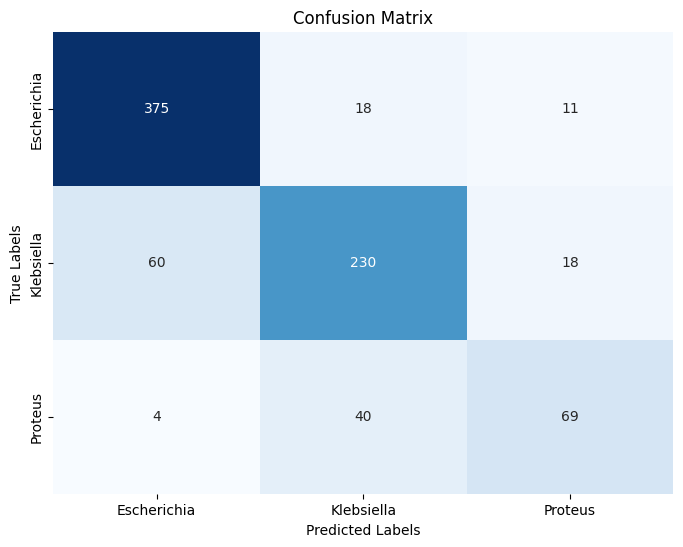

In [ ]:
best_params = grid_res.best_params_

model_RF = RandomForestClassifier(random_state=42, criterion="gini", max_depth=10, n_estimators=300)


train_and_evaluate_pipeline(X_train, Y_train, X_test, Y_test, model_RF)

In [ ]:
explainer_rf = shap.Explainer(model_RF)
shap_values_rf = explainer_rf(X_train)

In [ ]:
import numpy as np
print(np.shape(shap_values_rf))

(5070, 10, 3)


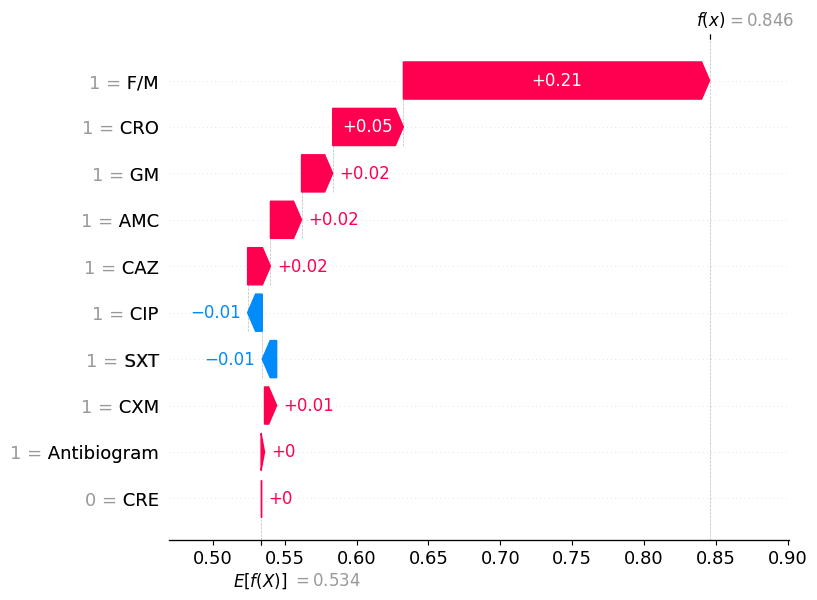

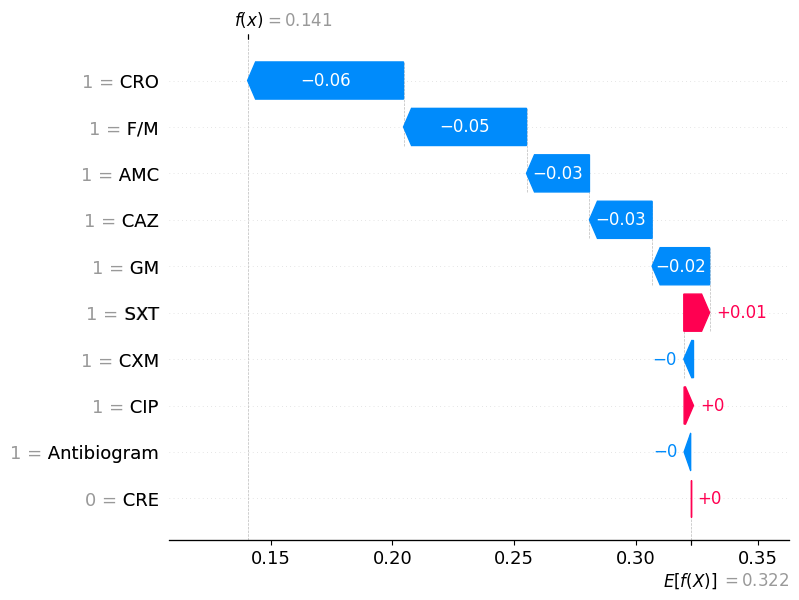

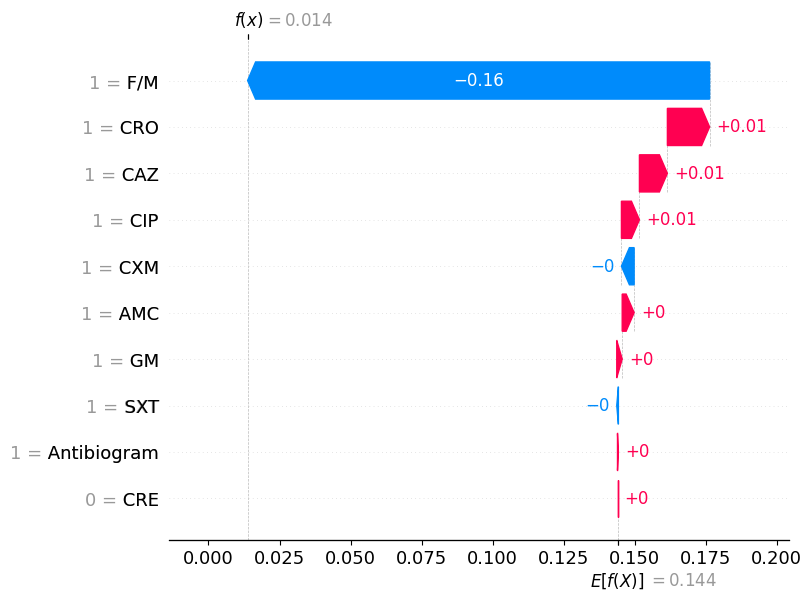

In [ ]:
shap.plots.waterfall(shap_values_rf[0,:,0])
shap.plots.waterfall(shap_values_rf[0,:,1])
shap.plots.waterfall(shap_values_rf[0,:,2])

In [ ]:
mean_escherichia = np.mean(np.abs(shap_values_rf.values[:,:,0]), axis=0)
mean_klebsiella = np.mean(np.abs(shap_values_rf.values[:,:,1]), axis=0)
mean_proteus = np.mean(np.abs(shap_values_rf.values[:,:,2]), axis=0)

In [ ]:
features_rf_df = pd.DataFrame({"Escherichia": mean_escherichia, "Klebsiella": mean_klebsiella, "Proteus": mean_proteus})

In [ ]:
features_rf_df

,Escherichia,Klebsiella,Proteus
0,0.000000,0.000000,0.000000
1,0.003061,0.004031,0.000970
2,0.037203,0.048884,0.012370
3,0.029635,0.048312,0.019560
4,0.018578,0.013022,0.018551
5,0.067735,0.092271,0.024833
6,0.028246,0.019627,0.011264
7,0.212074,0.071187,0.145660
8,0.031546,0.033246,0.006625
9,0.019641,0.018333,0.007507


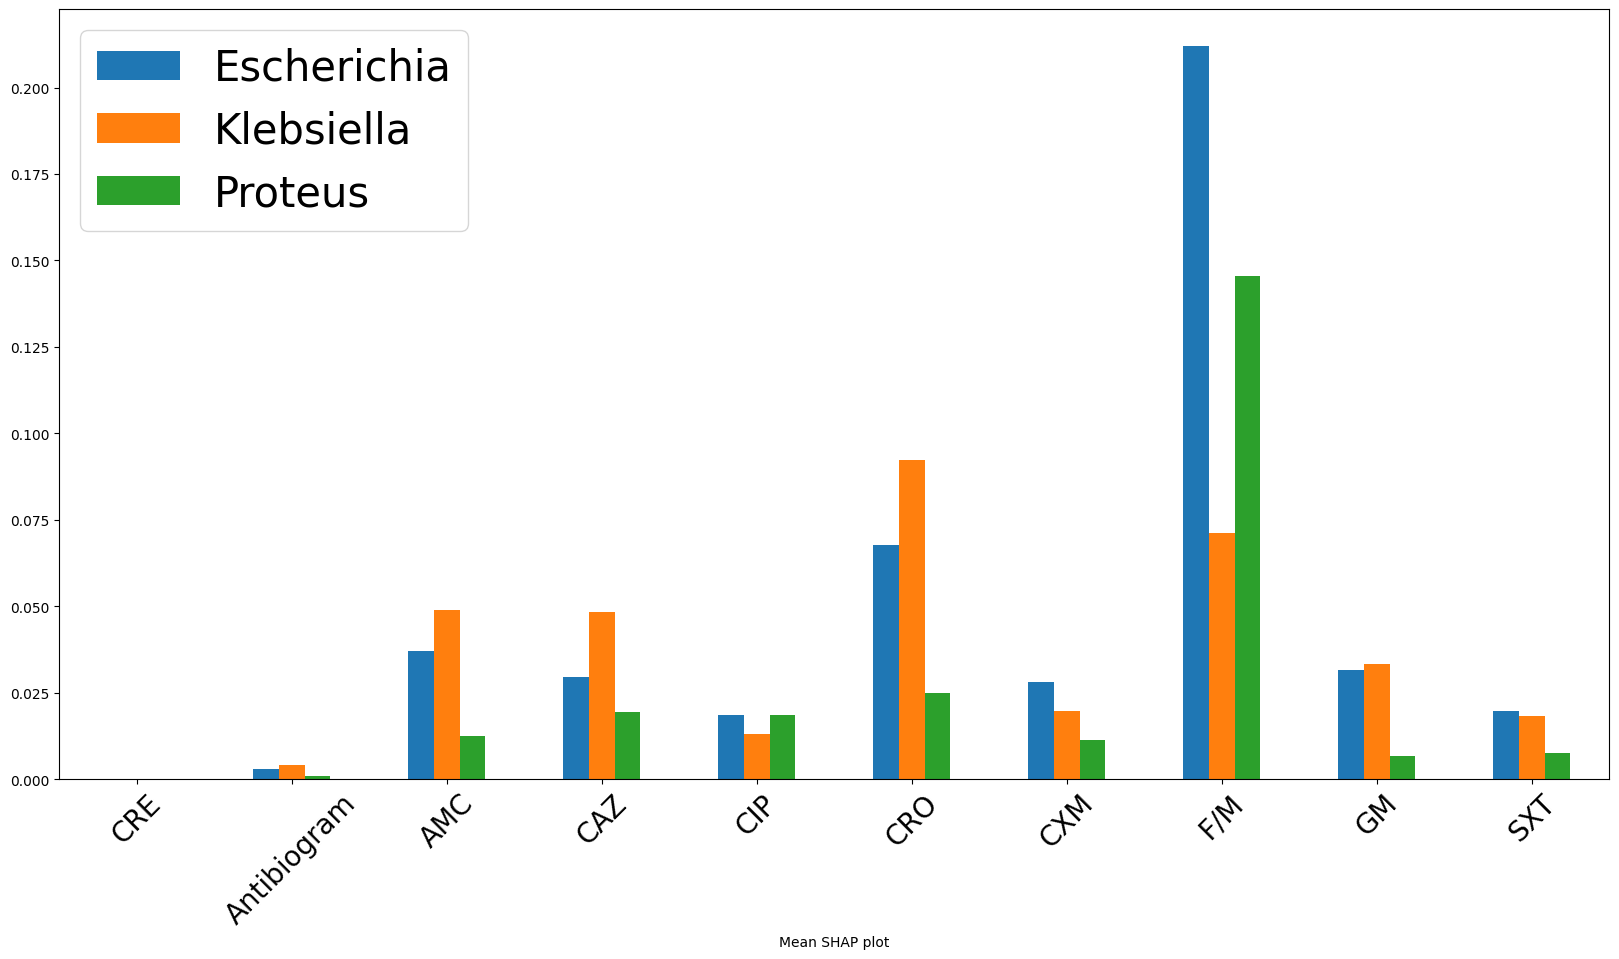

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
features_rf_df.plot.bar(ax=ax)
ax.set_xlabel("Mean SHAP plot", size=10)
ax.set_xticklabels(X_train.columns, rotation=45, size=20)
ax.legend(fontsize=30)
plt.show()

In [ ]:
 models = [{"label": "RandomForest", "model": model_RF}]

Random Forest Classifier OnevsOne classifier

Cross-Validation Accuracy: 0.7519
Test Set Accuracy: 0.8109
Test Set Precision: 0.8070
Test Set Recall: 0.8109
Test Set F1 Score: 0.8077


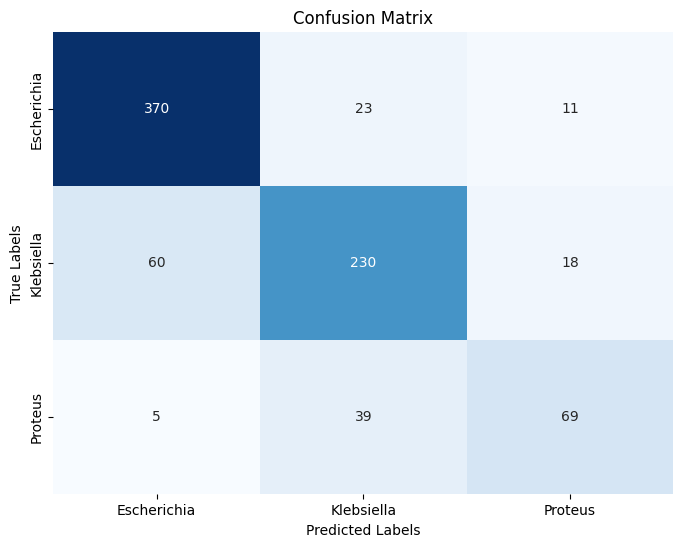

In [ ]:
best_params = grid_res.best_params_

model_RF_onevsone = OneVsOneClassifier(RandomForestClassifier(random_state=42, criterion="gini", max_depth=10, n_estimators=300)
)

train_and_evaluate_pipeline(X_train, Y_train, X_test, Y_test, model_RF_onevsone)

In [ ]:
 models.append({"label": "RandomForest_OnevsOne", "model": model_RF_onevsone})

Random Forest Classifier OnevsRest classifier

Cross-Validation Accuracy: 0.7554
Test Set Accuracy: 0.8182
Test Set Precision: 0.8141
Test Set Recall: 0.8182
Test Set F1 Score: 0.8145


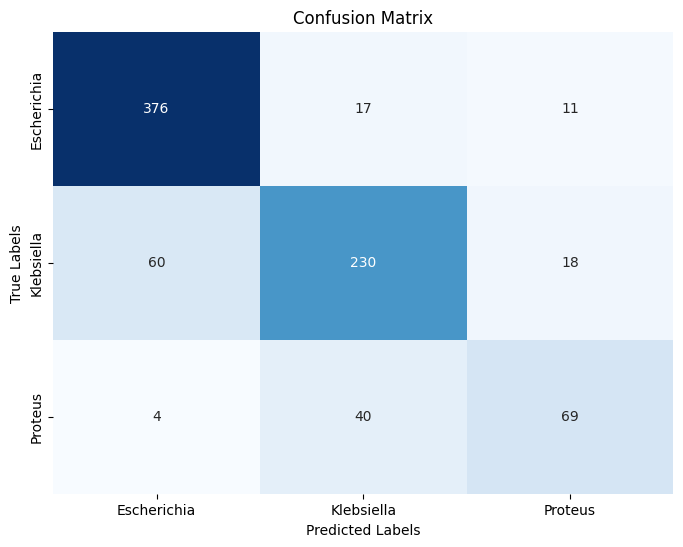

In [ ]:
best_params = grid_res.best_params_

model_RF_onevsrest = OneVsRestClassifier(RandomForestClassifier(random_state=42, criterion="gini", max_depth=10, n_estimators=300))

train_and_evaluate_pipeline(X_train, Y_train, X_test, Y_test, model_RF_onevsrest)

In [ ]:
 models.append({"label": "RandomForest_OnevsRest", "model": model_RF_onevsrest})

#XGBoost


Cross-Validation Accuracy: 0.7434
Test Set Accuracy: 0.8073
Test Set Precision: 0.8032
Test Set Recall: 0.8073
Test Set F1 Score: 0.8039


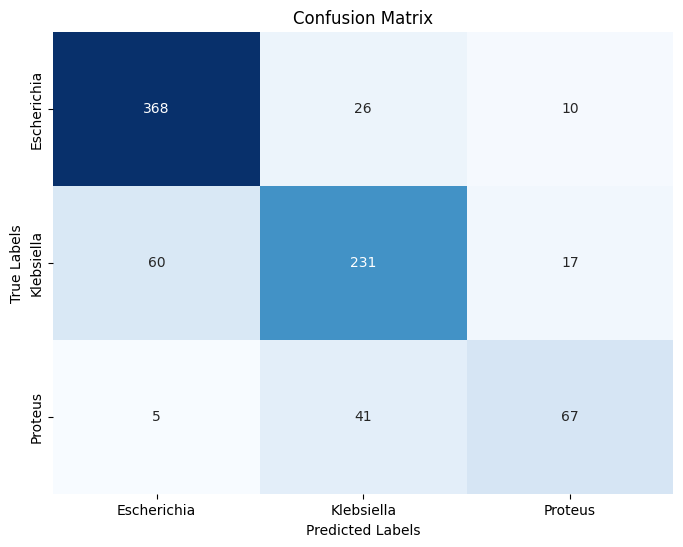

In [ ]:
import xgboost as xgb


xgb_model = xgb.XGBClassifier()
train_and_evaluate_pipeline(X_train, Y_train, X_test, Y_test, xgb_model)

In [ ]:
models_XGB = [{"label": "XGBoost", "model": xgb_model}]

In [ ]:
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(X_train)

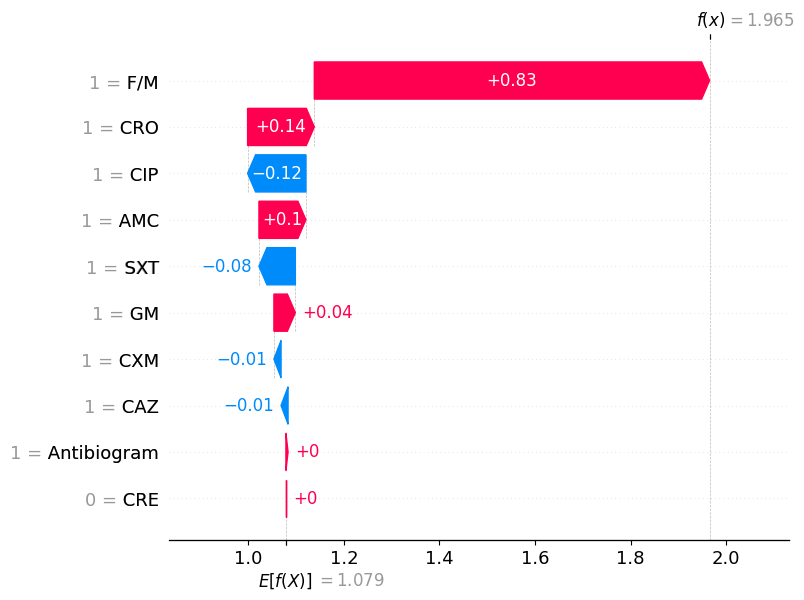

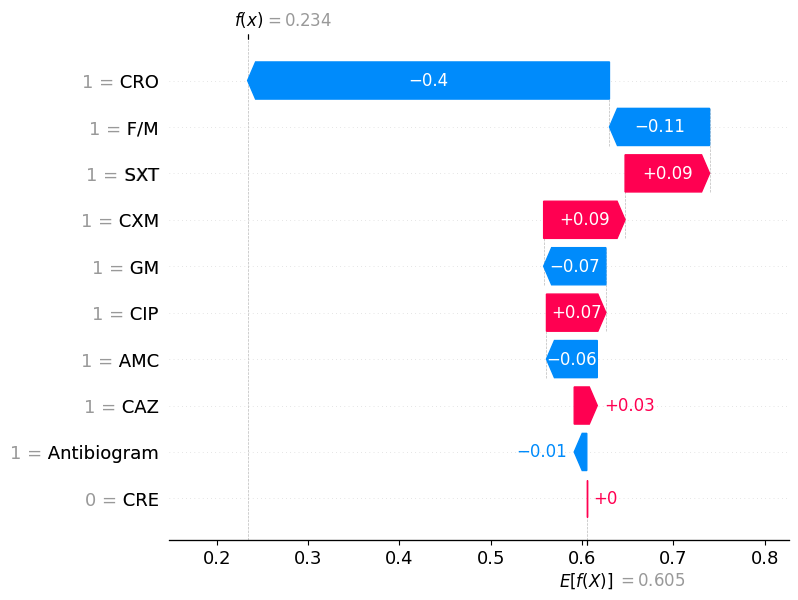

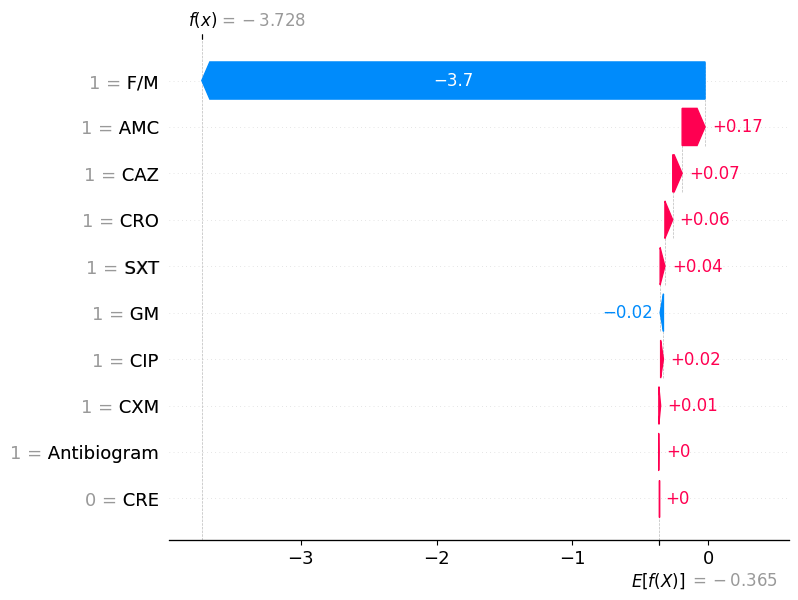

In [ ]:
shap.plots.waterfall(shap_values_xgb[0,:,0])
shap.plots.waterfall(shap_values_xgb[0,:,1])
shap.plots.waterfall(shap_values_xgb[0,:,2])

In [ ]:
escherichia_mean_xgb = np.mean(np.abs(shap_values_xgb.values[:,:,0]),axis=0)
klebsiella_mean_xgb = np.mean(np.abs(shap_values_xgb.values[:,:,1]),axis=0)
proteus_mean_xgb = np.mean(np.abs(shap_values_xgb.values[:,:,2]),axis=0)

In [ ]:
features_xgb_df = pd.DataFrame({"Escherichia": escherichia_mean_xgb, "Klebsiella": klebsiella_mean_xgb, "Proteus": proteus_mean_xgb})

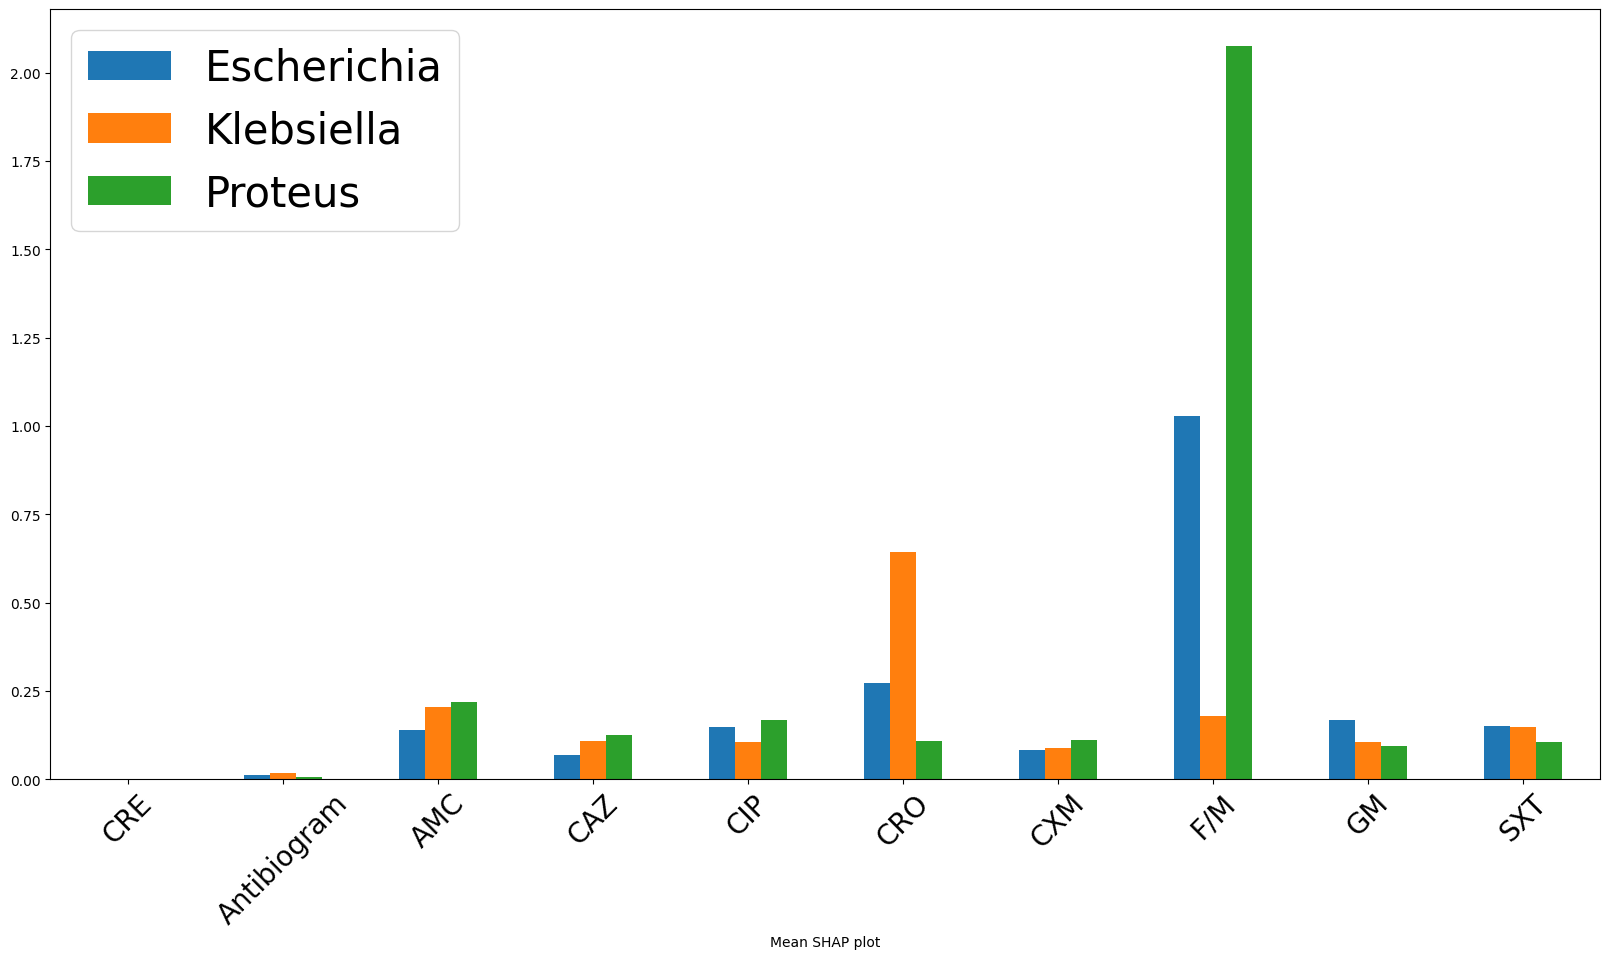

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
features_xgb_df.plot.bar(ax=ax)
ax.set_xlabel("Mean SHAP plot", size=10)
ax.set_xticklabels(X_train.columns, rotation=45, size=20)
ax.legend(fontsize=30)
plt.show()

OneVsOneClassifier XGBoost

Cross-Validation Accuracy: 0.7452
Test Set Accuracy: 0.8109
Test Set Precision: 0.8070
Test Set Recall: 0.8109
Test Set F1 Score: 0.8078


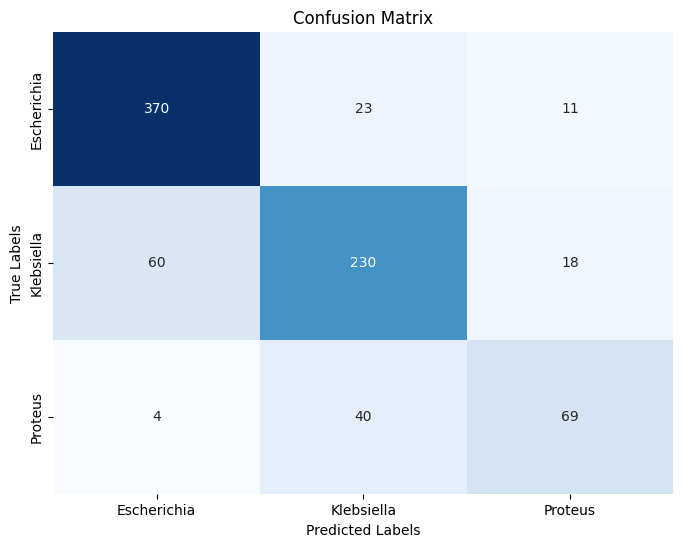

In [ ]:
xgb_model_onevsone = OneVsOneClassifier(xgb.XGBClassifier())
train_and_evaluate_pipeline(X_train, Y_train, X_test, Y_test, xgb_model_onevsone)

In [ ]:
models_XGB.append({"label": "XGBoost_OnevsRest", "model": xgb_model_onevsone})

OneVsRestClassifier XGBoost

Cross-Validation Accuracy: 0.7460
Test Set Accuracy: 0.8073
Test Set Precision: 0.8032
Test Set Recall: 0.8073
Test Set F1 Score: 0.8039


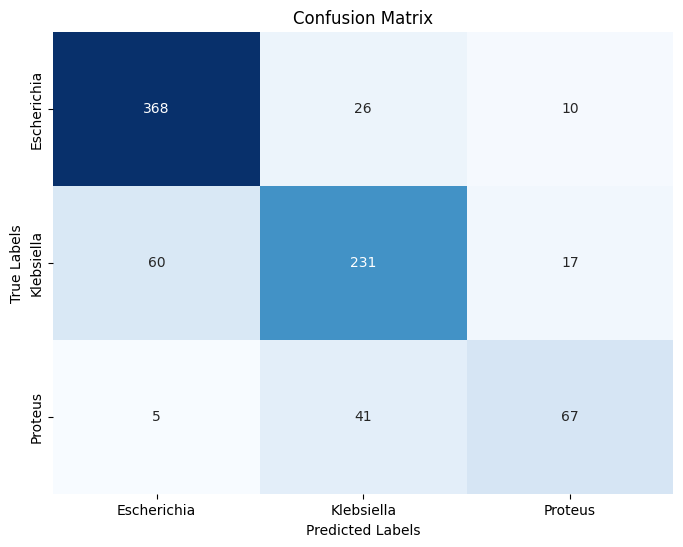

In [ ]:
xgb_model_onevsrest = OneVsRestClassifier(xgb.XGBClassifier())
train_and_evaluate_pipeline(X_train, Y_train, X_test, Y_test, xgb_model_onevsrest)

In [ ]:
models_XGB.append({"label": "XGBoost_OnevsOne", "model": xgb_model_onevsone})

# Artifical Neural Networks

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import torch
from sklearn.preprocessing import OneHotEncoder

category_mapping = {'missing': 0, 'S': 1, 'I': 2, 'R': 3}
selected_columns = ["AMC", "CAZ", "CIP", "CRO", "CXM", "F/M", "GM", "SXT"]

encoder = OrdinalEncoder()
X_train[selected_columns] = X_train[selected_columns].replace(category_mapping).astype(float)

X_test[selected_columns] = X_test[selected_columns].replace(category_mapping).astype(float)

encoder = OneHotEncoder(sparse_output=False)

Y_train_encoded = encoder.fit_transform(Y_train.values.reshape(-1, 1))
Y_test_encoded = encoder.fit_transform(Y_test.values.reshape(-1, 1))


X_train_tensor = torch.FloatTensor(X_train.values)
Y_train_tensor = torch.FloatTensor(Y_train_encoded)

X_test_tensor = torch.FloatTensor(X_test.values)
Y_test_tensor = torch.FloatTensor(Y_test_encoded)
torch.manual_seed(42)


In [ ]:
class ComplexMulticlass(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(ComplexMulticlass, self).__init__()
        layers = []
        for i in range(len(hidden_sizes)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_sizes[i]))
            else:
                layers.append(nn.Linear(hidden_sizes[i-1], hidden_sizes[i]))
            layers.append(nn.ReLU())
        self.hidden_layers = nn.Sequential(*layers)
        self.output = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        x = self.hidden_layers(x)
        x = self.output(x)
        return x

In [ ]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.6 MB/s eta 0:00:00


In [ ]:
import optuna
def hyperparameter_tunning(trial):
    input_size = X_train_tensor.shape[1]
    output_size = Y_train_tensor.shape[1]
    hidden_sizes = [trial.suggest_int(f'hidden_size_{i}', 32, 256) for i in range(trial.suggest_int('num_hidden_layers', 1, 4))]

    model = ComplexMulticlass(input_size, hidden_sizes, output_size)

    optimizer = optim.SGD(model.parameters(), lr=trial.suggest_float('lr', 1e-5, 1e-1))
    criterion = nn.CrossEntropyLoss()

    Y_train_tensor_long = torch.argmax(Y_train_tensor, dim=1).long()

    num_epochs = 10
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor_long)
        loss.backward()
        optimizer.step()

    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == torch.argmax(Y_test_tensor, dim=1).long()).sum().item()
        accuracy = correct / len(Y_test_tensor)

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(hyperparameter_tunning, n_trials=50)

best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2024-04-29 23:53:33,486] A new study created in memory with name: no-name-35998aa2-2522-4b34-91d1-73ee9883b310
[I 2024-04-29 23:53:37,689] Trial 0 finished with value: 0.4896969696969697 and parameters: {'num_hidden_layers': 4, 'hidden_size_0': 160, 'hidden_size_1': 75, 'hidden_size_2': 109, 'hidden_size_3': 191, 'lr': 0.04605416345794098}. Best is trial 0 with value: 0.4896969696969697.
[I 2024-04-29 23:53:38,235] Trial 1 finished with value: 0.4896969696969697 and parameters: {'num_hidden_layers': 3, 'hidden_size_0': 217, 'hidden_size_1': 87, 'hidden_size_2': 123, 'lr': 0.02600357506214145}. Best is trial 0 with value: 0.4896969696969697.
[I 2024-04-29 23:53:38,321] Trial 2 finished with value: 0.45454545454545453 and parameters: {'num_hidden_layers': 1, 'hidden_size_0': 82, 'lr': 0.013805642917020935}. Best is trial 0 with value: 0.4896969696969697.
[I 2024-04-29 23:53:38,413] Trial 3 finished with value: 0.673939393939394 and parameters: {'num_hidden_layers': 1, 'hidden_size_0':

Best Hyperparameters: {'num_hidden_layers': 3, 'hidden_size_0': 125, 'hidden_size_1': 56, 'hidden_size_2': 177, 'lr': 0.08967201945545313}


Epoch 0: 100%|██████████| 1014/1014 [00:07<00:00, 138.28batch/s, acc=1, loss=0.374]


Epoch 0 validation: Cross-entropy=0.5809314846992493, Accuracy=0.7903030514717102, F1=0.7887442645297965, Recall=0.7903030303030303, Precision=0.7839753181838738
Confusion Matrix:
[[382   7  15]
 [ 80 204  24]
 [  8  39  66]]


Epoch 1: 100%|██████████| 1014/1014 [00:08<00:00, 126.60batch/s, acc=1, loss=0.39]


Epoch 1 validation: Cross-entropy=0.5628126263618469, Accuracy=0.7915151715278625, F1=0.78976676990384, Recall=0.7915151515151515, Precision=0.7849876013592142
Confusion Matrix:
[[383   7  14]
 [ 80 204  24]
 [  8  39  66]]


Epoch 2: 100%|██████████| 1014/1014 [00:08<00:00, 126.02batch/s, acc=1, loss=0.367]


Epoch 2 validation: Cross-entropy=0.5536725521087646, Accuracy=0.803636372089386, F1=0.7996102319337758, Recall=0.8036363636363636, Precision=0.7978950688045396
Confusion Matrix:
[[383   9  12]
 [ 72 214  22]
 [  5  42  66]]


Epoch 3: 100%|██████████| 1014/1014 [00:08<00:00, 118.82batch/s, acc=1, loss=0.417]


Epoch 3 validation: Cross-entropy=0.5587416291236877, Accuracy=0.7951515316963196, F1=0.7930091858439989, Recall=0.7951515151515152, Precision=0.7882588721672983
Confusion Matrix:
[[385   7  12]
 [ 80 205  23]
 [  8  39  66]]


Epoch 4: 100%|██████████| 1014/1014 [00:08<00:00, 125.99batch/s, acc=1, loss=0.37]


Epoch 4 validation: Cross-entropy=0.5662264227867126, Accuracy=0.7951515316963196, F1=0.7930091858439989, Recall=0.7951515151515152, Precision=0.7882588721672983
Confusion Matrix:
[[385   7  12]
 [ 80 205  23]
 [  8  39  66]]


Epoch 5: 100%|██████████| 1014/1014 [00:08<00:00, 123.83batch/s, acc=1, loss=0.372]


Epoch 5 validation: Cross-entropy=0.5671160221099854, Accuracy=0.7939394116401672, F1=0.7916135247208932, Recall=0.793939393939394, Precision=0.7866579698986006
Confusion Matrix:
[[386   7  11]
 [ 80 204  24]
 [  9  39  65]]


Epoch 6: 100%|██████████| 1014/1014 [00:07<00:00, 134.60batch/s, acc=1, loss=0.357]


Epoch 6 validation: Cross-entropy=0.5587087273597717, Accuracy=0.8048484921455383, F1=0.8005033287699955, Recall=0.8048484848484848, Precision=0.7996049891631696
Confusion Matrix:
[[381  11  12]
 [ 69 217  22]
 [  5  42  66]]


Epoch 7: 100%|██████████| 1014/1014 [00:07<00:00, 131.54batch/s, acc=0.8, loss=0.366]


Epoch 7 validation: Cross-entropy=0.5463537573814392, Accuracy=0.803636372089386, F1=0.7990545454545455, Recall=0.8036363636363636, Precision=0.7988651390199684
Confusion Matrix:
[[378  14  12]
 [ 67 219  22]
 [  5  42  66]]


Epoch 8: 100%|██████████| 1014/1014 [00:07<00:00, 127.20batch/s, acc=1, loss=0.356]


Epoch 8 validation: Cross-entropy=0.5427168607711792, Accuracy=0.8048484921455383, F1=0.8003160341872312, Recall=0.8048484848484848, Precision=0.7998787497580961
Confusion Matrix:
[[379  13  12]
 [ 68 219  21]
 [  5  42  66]]


Epoch 9: 100%|██████████| 1014/1014 [00:08<00:00, 122.90batch/s, acc=1, loss=0.303]


Epoch 9 validation: Cross-entropy=0.5490906238555908, Accuracy=0.803636372089386, F1=0.8000003193374718, Recall=0.8036363636363636, Precision=0.79910442193325
Confusion Matrix:
[[379  13  12]
 [ 67 216  25]
 [  5  40  68]]


Epoch 10: 100%|██████████| 1014/1014 [00:08<00:00, 119.53batch/s, acc=1, loss=0.322]


Epoch 10 validation: Cross-entropy=0.5339533090591431, Accuracy=0.8060606122016907, F1=0.8012360522998822, Recall=0.806060606060606, Precision=0.8017572850345476
Confusion Matrix:
[[376  16  12]
 [ 64 223  21]
 [  4  43  66]]


Epoch 11: 100%|██████████| 1014/1014 [00:09<00:00, 110.83batch/s, acc=1, loss=0.308]


Epoch 11 validation: Cross-entropy=0.5424960255622864, Accuracy=0.8096969723701477, F1=0.804849215670507, Recall=0.8096969696969697, Precision=0.8045482164032925
Confusion Matrix:
[[381  11  12]
 [ 66 222  20]
 [  5  43  65]]


Epoch 12: 100%|██████████| 1014/1014 [00:07<00:00, 130.66batch/s, acc=1, loss=0.306]


Epoch 12 validation: Cross-entropy=0.5350787043571472, Accuracy=0.8096969723701477, F1=0.8051497647140525, Recall=0.8096969696969697, Precision=0.8050326031531246
Confusion Matrix:
[[380  12  12]
 [ 66 221  21]
 [  3  43  67]]


Epoch 13: 100%|██████████| 1014/1014 [00:07<00:00, 142.92batch/s, acc=1, loss=0.271]


Epoch 13 validation: Cross-entropy=0.5511572360992432, Accuracy=0.8060606122016907, F1=0.802536730045516, Recall=0.806060606060606, Precision=0.8012354162731316
Confusion Matrix:
[[381  11  12]
 [ 68 216  24]
 [  5  40  68]]


Epoch 14: 100%|██████████| 1014/1014 [00:08<00:00, 119.61batch/s, acc=1, loss=0.291]


Epoch 14 validation: Cross-entropy=0.5382417440414429, Accuracy=0.8096969723701477, F1=0.8060650401053086, Recall=0.8096969696969697, Precision=0.8056178313443514
Confusion Matrix:
[[379  13  12]
 [ 64 220  24]
 [  4  40  69]]


Epoch 15: 100%|██████████| 1014/1014 [00:09<00:00, 107.00batch/s, acc=1, loss=0.303]


Epoch 15 validation: Cross-entropy=0.5360410213470459, Accuracy=0.8096969723701477, F1=0.8057533503833314, Recall=0.8096969696969697, Precision=0.8058320233656527
Confusion Matrix:
[[376  16  12]
 [ 64 223  21]
 [  4  40  69]]


Epoch 16: 100%|██████████| 1014/1014 [00:08<00:00, 119.00batch/s, acc=1, loss=0.292]


Epoch 16 validation: Cross-entropy=0.5418127775192261, Accuracy=0.8084848523139954, F1=0.8040053556666564, Recall=0.8084848484848485, Precision=0.8040660692121916
Confusion Matrix:
[[378  14  12]
 [ 65 222  21]
 [  4  42  67]]


Epoch 17: 100%|██████████| 1014/1014 [00:07<00:00, 131.56batch/s, acc=1, loss=0.297]


Epoch 17 validation: Cross-entropy=0.5398687720298767, Accuracy=0.8121212124824524, F1=0.8084000792236088, Recall=0.8121212121212121, Precision=0.8077273957518137
Confusion Matrix:
[[380  12  12]
 [ 66 221  21]
 [  4  40  69]]


Epoch 18: 100%|██████████| 1014/1014 [00:07<00:00, 126.82batch/s, acc=1, loss=0.286]


Epoch 18 validation: Cross-entropy=0.5431053042411804, Accuracy=0.8145454525947571, F1=0.8109118725871608, Recall=0.8145454545454546, Precision=0.8097250285545554
Confusion Matrix:
[[383   9  12]
 [ 66 221  21]
 [  5  40  68]]


Epoch 19: 100%|██████████| 1014/1014 [00:08<00:00, 125.37batch/s, acc=1, loss=0.287]


Epoch 19 validation: Cross-entropy=0.5433642864227295, Accuracy=0.8145454525947571, F1=0.810085782113432, Recall=0.8145454545454546, Precision=0.8100054100614357
Confusion Matrix:
[[380  12  12]
 [ 64 225  19]
 [  4  42  67]]


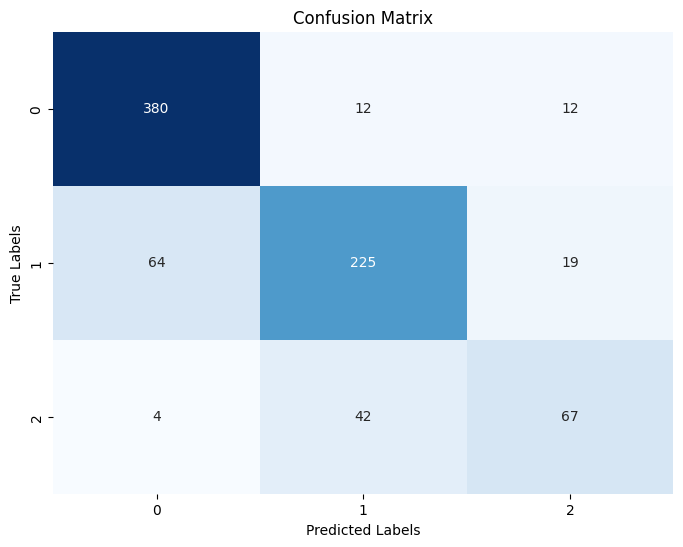

<All keys matched successfully>

In [ ]:
import tqdm
import numpy as np
import copy
import tqdm
import numpy as np
import copy
import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support



best_params = {'num_hidden_layers': 3, 'hidden_size_0': 246, 'hidden_size_1': 169, 'hidden_size_2': 156, 'lr': 0.08932809491083113}

input_size = X_train_tensor.shape[1]
output_size = Y_train_tensor.shape[1]
num_hidden_layers = best_params['num_hidden_layers']
hidden_sizes = [best_params[f'hidden_size_{i}'] for i in range(num_hidden_layers)]
lr = best_params['lr']
model_ANN = ComplexMulticlass(input_size, hidden_sizes, output_size)

optimizer = optim.SGD(model_ANN.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

Y_train_tensor_long = torch.argmax(Y_train_tensor, dim=1).long()

n_epochs = 20
batch_size = 5
batches_per_epoch = len(X_train_tensor) // batch_size

best_acc = -np.inf
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []
test_f1_hist = []
test_recall_hist = []
test_precision_hist = []
conf_matrix_hist = []

Y_train_tensor_long = torch.argmax(Y_train_tensor, dim=1).long()

for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    model_ANN.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # batch
            start = i * batch_size
            X_batch = X_train_tensor[start:start+batch_size]
            Y_batch = Y_train_tensor[start:start+batch_size]
            # forward pass
            y_pred = model_ANN(X_batch)
            loss = criterion(y_pred, torch.argmax(Y_batch, dim=1).long())
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(Y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )

    model_ANN.eval()
    y_pred = model_ANN(X_test_tensor)
    ce = criterion(y_pred, torch.argmax(Y_test_tensor, dim=1).long())
    acc = (torch.argmax(y_pred, 1) == torch.argmax(Y_test_tensor, 1)).float().mean()

    y_true = torch.argmax(Y_test_tensor, dim=1).numpy()
    y_pred = torch.argmax(y_pred, dim=1).numpy()

    f1, recall, precision, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    test_f1_hist.append(f1)
    test_recall_hist.append(recall)
    test_precision_hist.append(precision)


    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model_ANN.state_dict())

    print(f"Epoch {epoch} validation: Cross-entropy={ce}, Accuracy={acc}, F1={f1}, Recall={recall}, Precision={precision}")
    print(f'Confusion Matrix:\n{cm}')
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
model_ANN.load_state_dict(best_weights)


In [ ]:
model_ANNs = ({"label": "model_ANNs", "model": model_ANN})

In [ ]:
from torch.autograd import Variable

f = lambda x: model_ANN( Variable( torch.from_numpy(x) ) ).detach().numpy()
data = X_train.to_numpy(dtype=np.float32)

In [ ]:

explainer = shap.KernelExplainer(f, data)

shap_values = explainer.shap_values(data)

shap.initjs()


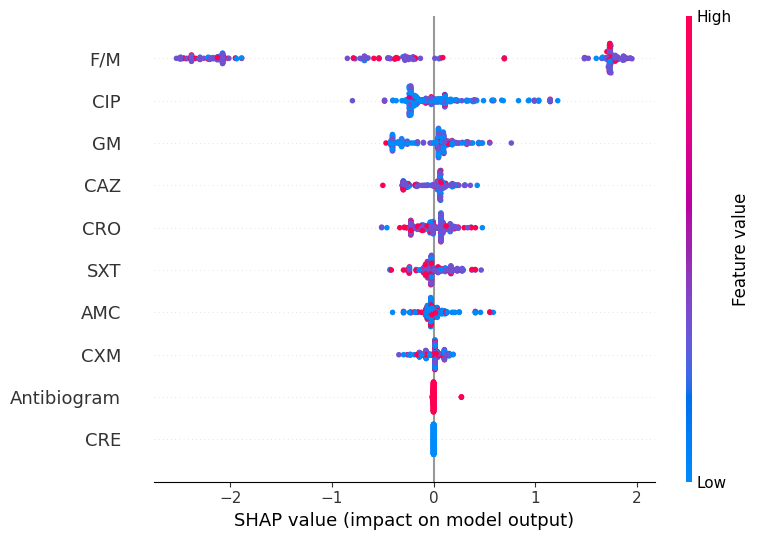

In [ ]:
feature_names = X_train.columns

# Plots

shap.summary_plot(shap_values[:,:,0],X_train[],feature_names=feature_names)

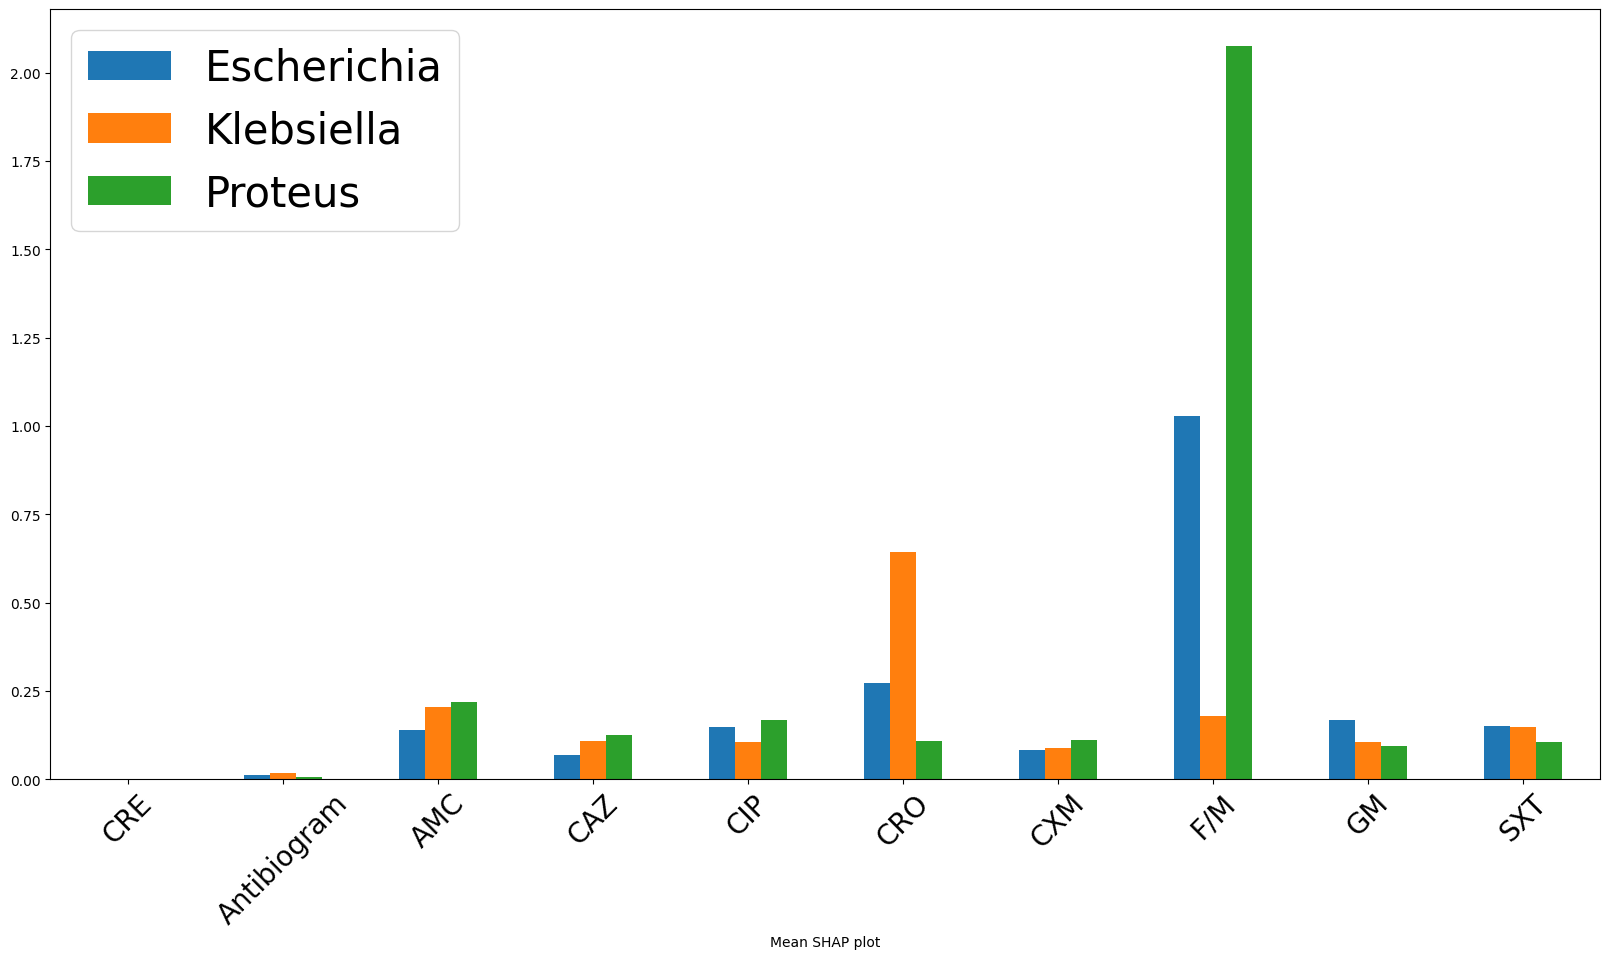

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
features_xgb_df.plot.bar(ax=ax)
ax.set_xlabel("Mean SHAP plot", size=10)
ax.set_xticklabels(X_train.columns, rotation=45, size=20)
ax.legend(fontsize=30)
plt.show()

# Cross validation on external dataset

In [ ]:
validate_df = pd.read_csv("/content/drive/MyDrive/Master_data/CSV/Bolnicki/validate_bolnicki.csv", index_col=[0])
category_mapping = {'missing': 0, 'S': 1, 'I': 2, 'R': 3}
selected_columns = ["CRE", "Antibiogram", "AMC", "CAZ", "CIP", "CRO", "CXM", "F/M", "GM", "SXT"]
validate_df['CRE'] = validate_df['CRE'].apply(lambda x: 1 if x == 'Y' else 0)
validate_df['Antibiogram'] = validate_df['Antibiogram'].apply(lambda x: 1 if x == 'D' else 0)
X_validate = validate_df[selected_columns].replace(category_mapping).astype(float)
Y_validate = validate_df["Naziv bakterije"]

In [ ]:
validate_df

,Spol,Dob,Mjesto,Datum nar.,Odjel,Tra?eno,Naziv bakterije,CRE,Antibiogram,AMC,CAZ,CIP,CRO,CXM,F/M,GM,SXT,Year
3821,M,79,GRAD MOSTAR,1/1/2021,3100,Urin-aerobno,Klebsiella,0,1,R,R,R,R,R,R,R,R,2021
3822,Z,80,MOSTAR,1/2/2021,2400,Urin-aerobno,Esch. coli,0,1,S,S,R,S,S,S,S,S,2021
3823,Z,71,MOSTAR,1/3/2021,3100,Urin-aerobno,Klebsiella,0,1,R,R,R,R,R,R,R,R,2021
3824,M,63,?IROKI BRIJEG,1/4/2021,2010,Urin-aerobno,Proteus,0,1,R,R,R,R,R,R,R,R,2021
3825,M,68,LIVNO,1/4/2021,2700,Urin-aerobno,Klebsiella,0,1,R,R,R,R,R,R,R,R,2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4611,Z,75,?ITLUK,12/28/2021,2100,Urin-aerobno,Esch. coli,0,1,S,S,S,missing,S,S,S,S,2021
4612,Z,68,?IROKI BRIJEG,12/30/2021,3100,Urin-aerobno,Proteus,0,1,R,R,S,missing,R,R,missing,S,2021
4613,Z,2,POSU?JE,12/30/2021,4330,Urin-aerobno,Esch. coli,0,1,S,S,missing,S,S,S,S,S,2021
4614,Z,2,MOSTAR,12/31/2021,4500,Urin-aerobno,Proteus,0,1,S,S,missing,S,missing,R,S,S,2021


In [ ]:
def cross_validate_models(X, Y, models):


    acc = []
    pre = []
    rec = []
    f1sc = []

    kfold = KFold(n_splits=10, shuffle=True, random_state=42)

    for model_name, model in models.items():
        print(f"Cross-validating {model_name}...")

        cloned_model = clone(model)

        accuracy_scores = cross_val_score(cloned_model, X, Y, cv=kfold, scoring='accuracy')
        precision_scores = cross_val_score(cloned_model, X, Y, cv=kfold, scoring='precision_macro')
        recall_scores = cross_val_score(cloned_model, X, Y, cv=kfold, scoring='recall_macro')
        f1_scores = cross_val_score(cloned_model, X, Y, cv=kfold, scoring='f1_macro')

        acc.append(accuracy_scores)
        pre.append(precision_scores)
        rec.append(recall_scores)
        f1sc.append(f1_scores)

    mean_acc = np.mean(acc)
    mean_pre = np.mean(pre)
    mean_rec = np.mean(rec)
    mean_f1sc = np.mean(f1sc)
    print(f"Mean accuracy: {mean_acc} \t"
        f"and std : {np.std(acc):.2f} \n"
        f"Mean precision: {mean_pre} \t"
        f"and std : {np.std(pre):.2f} \n"
        f"Mean recall: {mean_rec} \t"
        f"and std : {np.std(rec):.2f} \n"
        f"Mean F1: {mean_f1sc} \t"
        f"and std : {np.std(f1sc):.2f} \n"
    )


    return [mean_acc,mean_pre, mean_rec, mean_f1sc]

In [ ]:
cross_val_result = {}
for model in models:
    print("\n======= ")
    print(f"{model['label']}")

    classifier_model = model['model']

    results = cross_validate_models(X_validate, Y_validate, {model['label']: classifier_model})
    label = model['label']
    cross_val_result[label] = results
    print(results)



RandomForest
Cross-validating RandomForest...
Mean accuracy: 0.7849050632911392 	and std : 0.04 
Mean precision: 0.7583831928157432 	and std : 0.04 
Mean recall: 0.773598127532269 	and std : 0.05 
Mean F1: 0.7574558570137175 	and std : 0.04 

[0.7849050632911392, 0.7583831928157432, 0.773598127532269, 0.7574558570137175]

RandomForest_OnevsOne
Cross-validating RandomForest_OnevsOne...
Mean accuracy: 0.7862025316455696 	and std : 0.04 
Mean precision: 0.7608188092913697 	and std : 0.04 
Mean recall: 0.7743607797643844 	and std : 0.05 
Mean F1: 0.759286302467405 	and std : 0.04 

[0.7862025316455696, 0.7608188092913697, 0.7743607797643844, 0.759286302467405]

RandomForest_OnevsRest
Cross-validating RandomForest_OnevsRest...
Mean accuracy: 0.7861708860759493 	and std : 0.04 
Mean precision: 0.7604838303053141 	and std : 0.04 
Mean recall: 0.7744990284331699 	and std : 0.05 
Mean F1: 0.759469411557125 	and std : 0.04 

[0.7861708860759493, 0.7604838303053141, 0.7744990284331699, 0.7594694

In [ ]:
cross_val_result_XGB = {}
for model in models_XGB:
    print("\n======= ")
    print(f"{model['label']}")

    classifier_model = model['model']
    class_mapping = {'Esch. coli': 0, 'Klebsiella': 1, 'Proteus': 2}
    Y_train.unique()
    Y_val_boost = Y_validate.map(class_mapping)
    results = cross_validate_models(X_validate, Y_val_boost, {model['label']: classifier_model})
    label = model['label']
    cross_val_result_XGB[label] = results
    print(results)


XGBoost
Cross-validating XGBoost...
Mean accuracy: 0.7849525316455697 	and std : 0.03 
Mean precision: 0.7582381786036487 	and std : 0.04 
Mean recall: 0.7735428194545775 	and std : 0.04 
Mean F1: 0.7569123739701606 	and std : 0.04 

[0.7849525316455697, 0.7582381786036487, 0.7735428194545775, 0.7569123739701606]

XGBoost_OnevsRest
Cross-validating XGBoost_OnevsRest...
Mean accuracy: 0.7886708860759494 	and std : 0.04 
Mean precision: 0.7630528138748999 	and std : 0.04 
Mean recall: 0.7810666797087009 	and std : 0.05 
Mean F1: 0.7629377658346895 	and std : 0.04 

[0.7886708860759494, 0.7630528138748999, 0.7810666797087009, 0.7629377658346895]

XGBoost_OnevsOne
Cross-validating XGBoost_OnevsOne...
Mean accuracy: 0.7886708860759494 	and std : 0.04 
Mean precision: 0.7630528138748999 	and std : 0.04 
Mean recall: 0.7810666797087009 	and std : 0.05 
Mean F1: 0.7629377658346895 	and std : 0.04 

[0.7886708860759494, 0.7630528138748999, 0.7810666797087009, 0.7629377658346895]


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

def evaluate_model(model, X_val, Y_val, criterion):
    model.eval()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = len(X_val)
    acc = []
    pre = []
    rec = []
    f1sc = []

    with torch.no_grad():
        inputs = torch.tensor(X_val, dtype=torch.float32).to(device).clone().detach()
        labels = torch.tensor(Y_val, dtype=torch.long).to(device).clone().detach()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        precision, recall, f1, _ = precision_recall_fscore_support(Y_val, predicted, average='weighted')
        acc.append(correct_predictions / total_samples)
        pre.append(precision)
        rec.append(recall)
        f1sc.append(f1)

    mean_acc = np.mean(acc)
    mean_pre = np.mean(pre)
    mean_rec = np.mean(rec)
    mean_f1sc = np.mean(f1sc)

    print(f"Mean accuracy: {mean_acc} \t"
        f"and std : {np.std(acc):.2f} \n"
        f"Mean precision: {mean_pre} \t"
        f"and std : {np.std(pre):.2f} \n"
        f"Mean recall: {mean_rec} \t"
        f"and std : {np.std(rec):.2f} \n"
        f"Mean F1: {mean_f1sc} \t"
        f"and std : {np.std(f1sc):.2f} \n"
    )


    return [mean_acc, mean_pre, mean_rec, mean_f1sc]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model_ANNs = [{"label": "model_ANNs", "model": model_ANN}]

In [ ]:
result = {}
encoder = LabelEncoder()
Y_val_encoder = encoder.fit_transform(Y_validate.values.reshape(-1, 1))

X_val_tensor = torch.LongTensor(X_validate.values)
Y_val_tensor = torch.LongTensor(Y_val_encoder)

eval_model = evaluate_model(model_ANN, X_val_tensor, Y_val_tensor, criterion)
result["ANN"] = eval_model


Mean accuracy: 0.8138364779874214 	and std : 0.00 
Mean precision: 0.8238457621623132 	and std : 0.00 
Mean recall: 0.8138364779874214 	and std : 0.00 
Mean F1: 0.813129433923188 	and std : 0.00 



/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
<ipython-input-107-3ad96e114f4a>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs = torch.tensor(X_val, dtype=torch.float32).to(device).clone().detach()
<ipython-input-107-3ad96e114f4a>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(Y_val, dtype=torch.long).to(device).clone().detach()


In [ ]:
df2 = pd.DataFrame(cross_val_result, index=["Accuracy", "Precision", "Recall", "F1"])
df_xgb = pd.DataFrame(cross_val_result_XGB, index=["Accuracy", "Precision", "Recall", "F1"])
df_ann = pd.DataFrame(result, index=["Accuracy", "Precision", "Recall", "F1"])
df_final = pd.concat([df2, df_xgb, df_ann], axis=1)

df_final = df_final.T
df_final

,Accuracy,Precision,Recall,F1
RandomForest,0.784905,0.758383,0.773598,0.757456
RandomForest_OnevsOne,0.786203,0.760819,0.774361,0.759286
RandomForest_OnevsRest,0.786171,0.760484,0.774499,0.759469
XGBoost,0.784953,0.758238,0.773543,0.756912
XGBoost_OnevsRest,0.788671,0.763053,0.781067,0.762938
XGBoost_OnevsOne,0.788671,0.763053,0.781067,0.762938
ANN,0.813836,0.823846,0.813836,0.813129


In [ ]:
color=sns.color_palette('Set2')
feat = ["Accuracy", "Precision", "Recall", "F1"]
df_final[feat].plot.barh(figsize=(10,7),color=color)
plt.legend(frameon=False,bbox_to_anchor=(1,0.8), prop={'size':20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Model performances after K-fold cross-validation',size=20)